In [11]:
# main.py
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import kNN_modules
import random
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

plt.style.use('dark_background')


In [12]:
# Load and preprocess
df = pd.read_csv('Iris.csv')
df.drop(columns=['Id'], inplace=True)

scaler = MinMaxScaler()
features = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
df[features] = scaler.fit_transform(df[features])


species_to_numbers = {'Iris-setosa': 1, 'Iris-versicolor': 2, 'Iris-virginica': 3}
numbers_to_species = {v: k for k, v in species_to_numbers.items()}
df['SpeciesNum'] = df['Species'].map(species_to_numbers)


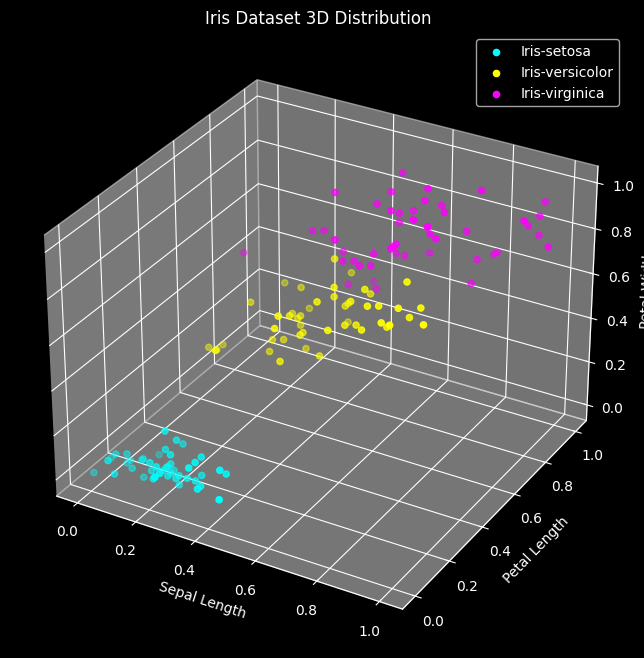

In [13]:
# Visualize data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for species, color in zip(species_to_numbers.keys(), ['cyan', 'yellow', 'magenta']):
    subset = df[df['Species'] == species]
    ax.scatter3D(subset['SepalLengthCm'], subset['PetalLengthCm'], subset['PetalWidthCm'], label=species, color=color)
ax.set_xlabel("Sepal Length")
ax.set_ylabel("Petal Length")
ax.set_zlabel("Petal Width")
ax.legend()
plt.title("Iris Dataset 3D Distribution")
plt.show()

In [14]:
# Prepare input/output
known_inputs = df[features].values.tolist()
known_outputs = df['SpeciesNum'].tolist()

# Function for splitting data
def test_train(full_inputs, full_outputs, percent_test):
    test_inputs, test_outputs, train_inputs, train_outputs = [], [], [], []
    number_test = int(len(full_inputs) * percent_test / 100)
    indices = list(range(len(full_inputs)))
    random.shuffle(indices)
    test_indices = set(indices[:number_test])
    for idx, item in enumerate(full_inputs):
        if idx in test_indices:
            test_inputs.append(item)
            test_outputs.append(full_outputs[idx])
        else:
            train_inputs.append(item)
            train_outputs.append(full_outputs[idx])
    return test_inputs, test_outputs, train_inputs, train_outputs



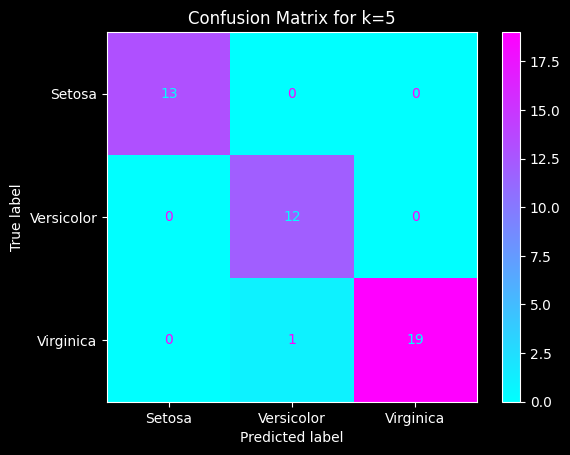

In [15]:
# Accuracy function
def accuracy(test_inputs, test_outputs, train_inputs, train_outputs, k_value):
    correct = sum(
        kNN_modules.KNN(test, train_inputs, train_outputs, k_value) == label
        for test, label in zip(test_inputs, test_outputs)
    )
    return (correct / len(test_inputs)) * 100

# Confusion Matrix
k = 5
test_inputs, test_outputs, train_inputs, train_outputs = test_train(known_inputs, known_outputs, 30)
predictions = [kNN_modules.KNN(test, train_inputs, train_outputs, k) for test in test_inputs]
cm = confusion_matrix(test_outputs, predictions, labels=[1,2,3])
cmd = ConfusionMatrixDisplay(cm, display_labels=['Setosa', 'Versicolor', 'Virginica'])
cmd.plot(cmap='cool')
plt.title(f"Confusion Matrix for k={k}")
plt.show()

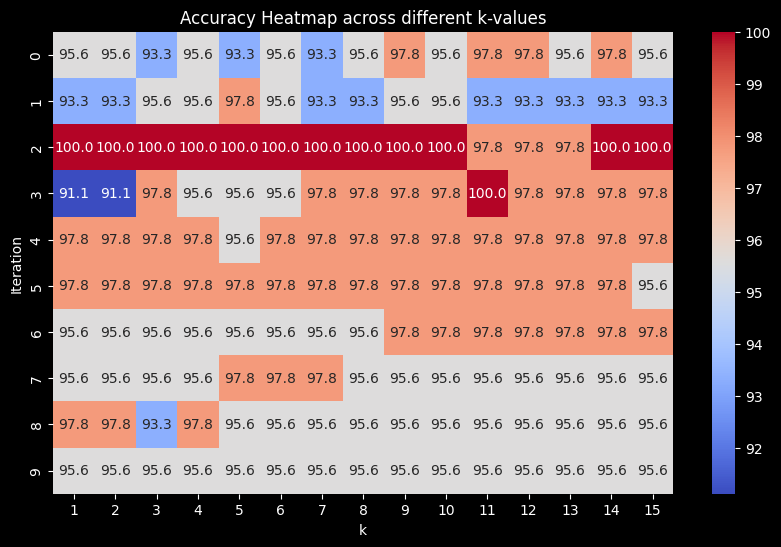

In [16]:
# Accuracy Heatmap
results = []
for i in range(10):
    test_inputs, test_outputs, train_inputs, train_outputs = test_train(known_inputs, known_outputs, 30)
    for k in range(1, 16):
        acc = accuracy(test_inputs, test_outputs, train_inputs, train_outputs, k)
        results.append({'k': k, 'iteration': i, 'accuracy': acc})

df_results = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
pivot_df = df_results.pivot(index='iteration', columns='k', values='accuracy')
sns.heatmap(pivot_df, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Accuracy Heatmap across different k-values")
plt.xlabel("k")
plt.ylabel("Iteration")
plt.show()

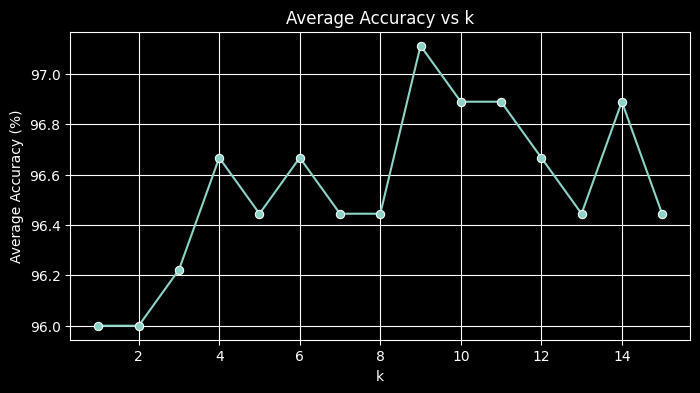

In [17]:
# Average Accuracy vs k
avg_acc = df_results.groupby('k')['accuracy'].mean().reset_index()
plt.figure(figsize=(8, 4))
sns.lineplot(x='k', y='accuracy', data=avg_acc, marker='o')
plt.title("Average Accuracy vs k")
plt.xlabel("k")
plt.ylabel("Average Accuracy (%)")
plt.grid(True)
plt.show()

# Export results to CSV
df_results.to_csv("knn_accuracy_results.csv", index=False)


In [18]:
# Best k value
best_k = avg_acc.loc[avg_acc['accuracy'].idxmax(), 'k']
print(f"Best k based on average accuracy: {int(best_k)}")

# Command-line test input
try:
    inp = input("Enter 4 features separated by space (SepalL SepalW PetalL PetalW): ").strip()
    q = [float(x) for x in inp.split()]
    query_df = pd.DataFrame([q], columns=features)
    q_scaled = scaler.transform(query_df)[0]
    prediction = kNN_modules.KNN(q_scaled, known_inputs, known_outputs, 5)
    print("Predicted Species:", numbers_to_species[prediction])
except Exception as e:
    print("Skipping manual query due to error or non-interactive mode.", e)


Best k based on average accuracy: 9
Enter 4 features separated by space (SepalL SepalW PetalL PetalW): 0.2 0.2 0.2 0.2
Predicted Species: Iris-setosa
